In [3]:
# Install the required libraries
#SAM
!pip3 install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip3 install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip3 install datasets
!pip3 install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip3 install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/b0/f4y8k0ss7jl74h0lpqt45wxc0000gp/T/pip-req-build-ovvr02lm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/b0/f4y8k0ss7jl74h0lpqt45wxc0000gp/T/pip-req-build-ovvr02lm
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# imports

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import patchify as patchify


# this function will be used to get an array of images from a folder

def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array


In [5]:
folder_path_images = 'Downloads/images only'
image_array = read_images_to_array(folder_path_images)

# this is based on if the image has a white pixel at 25, 100
# ussually this seperates the two image types

red_region_data = []
raw_data = []

for image in image_array:
  if image[25, 100].sum() == 255 * 3:
    red_region_data.append(image)
  else:
    raw_data.append(image)

Text(0.5, 1.0, 'Raw Image')

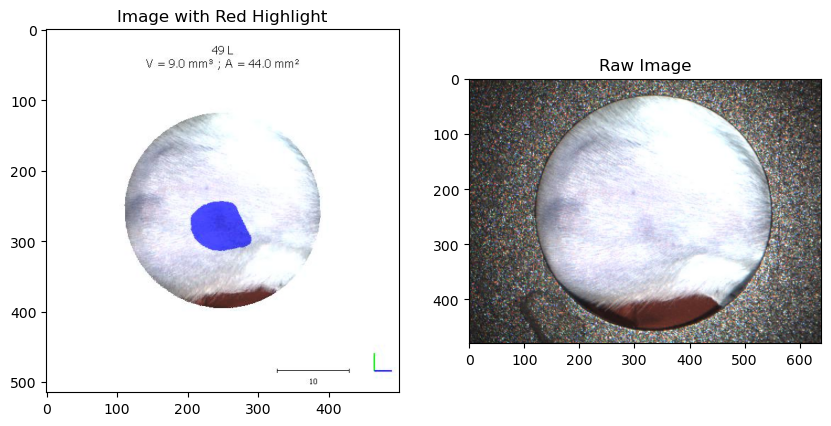

In [6]:
rand = random.randint(0, len(red_region_data) - 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(red_region_data[rand])
ax[0].set_title('Image with Red Highlight')

ax[1].imshow(raw_data[rand])
ax[1].set_title('Raw Image')

In [7]:
# first crop out raw images

raw_images_masked = []

# for loop

for i in range(len(raw_data) - 1):

  img = raw_data[i]

  mask = np.zeros(img.shape, dtype=np.uint8)
  mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

  res = cv2.bitwise_and(img, mask)
  res[mask==0] = 255

  raw_images_masked.append(res)

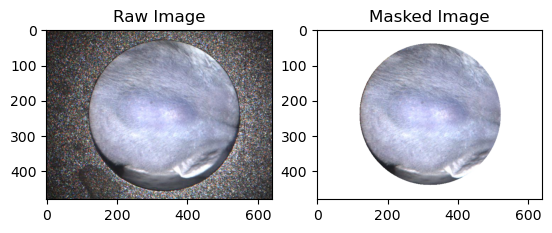

In [8]:
# random number

rand = random.randint(0, len(raw_images_masked) - 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(raw_data[rand])
ax[0].set_title("Raw Image")
ax[1].imshow(raw_images_masked[rand])
ax[1].set_title('Masked Image')

plt.show()

In [9]:
red_region_circle_masks = []

# for loop

for i in range(len(red_region_data) - 1):

  img = red_region_data[i]

  mask = np.zeros(img.shape, dtype=np.uint8)
  mask = cv2.circle(mask, (250, 257), 135, (255,255,255), -1)

  res = cv2.bitwise_and(img, mask)
  res[mask==0] = 255

  red_region_circle_masks.append(res)

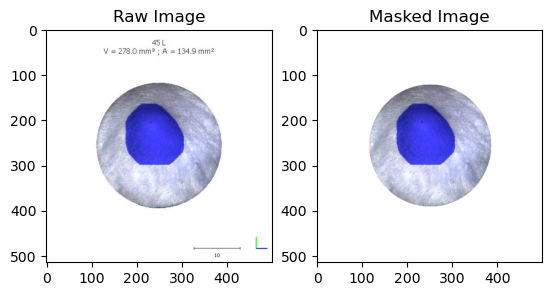

In [10]:
# random number

rand = random.randint(0, len(red_region_data) - 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(red_region_data[rand])
ax[0].set_title("Raw Image")
ax[1].imshow(red_region_circle_masks[rand])
ax[1].set_title('Masked Image')

plt.show()


In [11]:
# for loop to create masks

binary_masks = []

for image in red_region_circle_masks:

  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  lower_red = np.array([0,150,115])
  upper_red = np.array([255,255,255])


  mask = cv2.inRange(hsv, lower_red, upper_red)
  res = cv2.bitwise_and(image,image, mask= mask)


  binary_masks.append(mask)

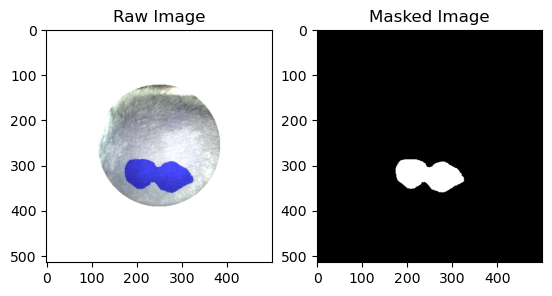

In [12]:
rand = random.randint(0, len(binary_masks) - 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(red_region_circle_masks[rand])
ax[0].set_title("Raw Image")
ax[1].imshow(binary_masks[rand], cmap = "gray")
ax[1].set_title('Masked Image')

plt.show()

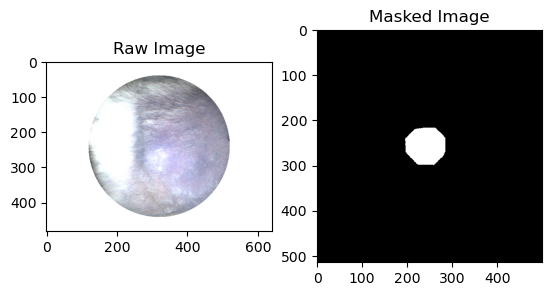

In [13]:
rand = random.randint(0, len(binary_masks) - 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(raw_images_masked[rand])
ax[0].set_title("Raw Image")
ax[1].imshow(binary_masks[rand], cmap = "gray")
ax[1].set_title('Masked Image')

plt.show()

In [15]:
from PIL import Image
import numpy as np

resized_binary_masks = []
for mask in binary_masks:
  y=0
  x=0
  h=480
  w=640
  crop = mask[y:y+h, x:x+w]

  resized_binary_masks.append(crop)

# now that we have cropped the height, we have to add padding to the width

import cv2

padding = 70

padded_masks = []
for mask in resized_binary_masks:
  padded_img = cv2.copyMakeBorder(mask, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
  padded_masks.append(padded_img)


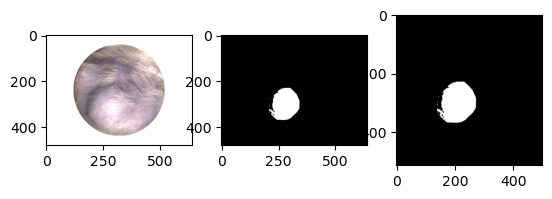

In [16]:
rand = random.randint(0, len(padded_masks) - 1)

fig, ax = plt.subplots(1,3)
ax[0].imshow(raw_images_masked[rand])
ax[1].imshow(padded_masks[rand], cmap = "gray")
ax[2].imshow(binary_masks[rand], cmap = "gray")

plt.show()

In [17]:
final_binary_masks = padded_masks

In [18]:
# convert lists to arrays
raw_images_masked = np.array(raw_images_masked)
final_binary_masks = np.array(final_binary_masks)

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in raw_images_masked],
    "label": [Image.fromarray(mask) for mask in final_binary_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

final_binary_masks.shape

(276, 480, 640)

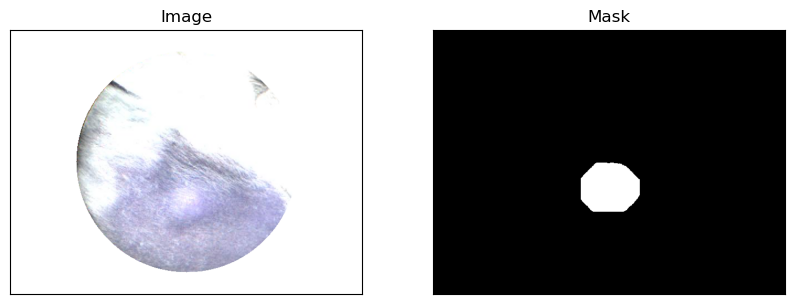

In [19]:
img_num = random.randint(0, raw_images_masked.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [20]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

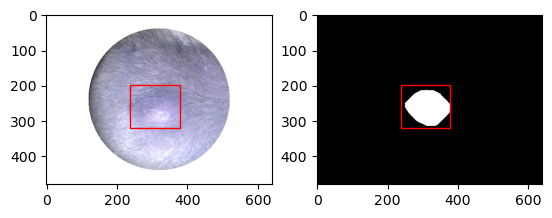

In [22]:
# test

import matplotlib.patches as patches # Import the patches module


rand = random.randint(0, len(final_binary_masks) - 1)

bbox1 = get_bounding_box(final_binary_masks[rand])

fig, ax = plt.subplots(1,2)
ax[0].imshow(raw_images_masked[rand])
ax[1].imshow(final_binary_masks[rand], cmap = "gray")

#
# Create a Rectangle patch
rect1 = patches.Rectangle((bbox1[0], bbox1[1]), bbox1[2] - bbox1[0], bbox1[3] - bbox1[1], linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((bbox1[0], bbox1[1]), bbox1[2] - bbox1[0], bbox1[3] - bbox1[1], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(rect1)
ax[1].add_patch(rect2)

plt.show()

In [23]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [24]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [25]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [26]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (480, 640)


In [27]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [28]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 480, 640])


In [29]:
batch["ground_truth_mask"].shape

torch.Size([2, 480, 640])

In [30]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)

      # Interpolate ground truth masks to match predicted mask size
      ground_truth_masks = nn.functional.interpolate(ground_truth_masks.unsqueeze(1),
                                                    size=predicted_masks.shape[-2:],
                                                    mode='bilinear',
                                                    align_corners=False).squeeze(1)

      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

In [ ]:
import torch

# Save the model to a subdirectory within the current working directory
torch.save(model.state_dict(), "/content/model/model3")

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/model/model3"))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, raw_images_masked.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:

rand = rand

single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()